In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans as k_means_sklearn

## Random ball - class

In [2]:
class sample_random_balls(object):
    
    def __init__(self, n_centers, var_x = 1, var_y = 1, var_xy = 0, x_range = [-10, 10], y_range = [-10, 10], rotate = False):
        """
        Want to sample K blobs, with n_points per blob. Diversity range is controlled by x_range and y_range
        """
        
        self.n_centers = n_centers
        self.covariance = np.array([[var_x, var_xy], 
                                    [var_xy, var_y]])
        
        self.x_centers = np.random.random_sample(n_centers) * (x_range[1] - x_range[0]) + x_range[0]
        self.y_centers = np.random.random_sample(n_centers) * (y_range[1] - y_range[0]) + y_range[0]
        
        self.mu = np.vstack([self.x_centers, self.y_centers]).T
    
    def sample(self, n_points):
        #Find any real matrix A such that A.A^T = Cov. If Cov is positive definite, Cholesky decomposition can be used.
        #Alternatively, use spectral decomposition Cov = U.S.U^(-1) (A = U.sqrt(S)) (U is the eigenvector matrix)
        #Let z = (z_1, ..., z_n)^T be a vector whose components are N independent standard normal variables
        #let x = mu + Az.
        
        #Positive definite - x^T A x > 0 for all x (all eigenvalues are positive)
        #Positive semi-definite - x^T A x >= 0 for all x (all eigenvalues are non-negative)
        
        eig_vals, eig_vect = np.linalg.eig(self.covariance)
        
        if np.sum(eig_vals > 0) == 2:
            print("\nCovariance is positive definite.")
            
            A = np.linalg.cholesky(self.covariance)
            
        elif np.sum(eig_vals >= 0) == 2:
            print("\nCovariance is positive semi-definite.")
            
            A = np.dot(eig_vect, np.diag(np.sqrt(eig_vals)))
        
        
        point_samples = np.random.randint(low = 0, high = self.n_centers, size = n_points)
        
        z = np.random.randn(n_points, 2)
        x = self.mu[point_samples, :] + np.dot(A, z.T).T
        
        return x, point_samples

## k-means class

In [3]:
class k_means(object):
    def __init__(self, n_clusters = 4, init = 'k-means++', n_init = 10, max_iter = 300, tol = 1e-4, verbose = False, random_state = None, copy_x = True, algorithm = 'auto', median_flag = False, vectorise = True):
        
        self.n_clusters = n_clusters #number of clusters to initialise
        self.init = init #'k-means++' selects initial clusters intelligently. 'random' chooses n_clusters rows at random
        self.n_init = n_init #Number of time the k-means algorithm will be run with different centroid seeds.
        self.max_iter = max_iter #max iterations for a single run
        self.tol = tol #Relative tolerance with regards to Frobenius norm of the difference in the cluster centers
        #of two consecutive iterations to declare convergence.
        self.verbose = verbose #If verbose = 1, print loss over iterations
        self.random_state = random_state #Determines random number generation for centroid initialisation
        self.copy_x = copy_x #Will not modify the original data, if False, data is centered and then uncentered
        self.algorithm = algorithm #EM or elkan
        self.median_flag = median_flag
        self.vectorise = vectorise #To try and vectorise the loops
        
        if random_state is not None:
            np.random.RandomState(self.random_state)
        
        #initialised parameters
        #self.cluster_centers_ = None #coordinates of cluster centers.
        #self.labels_ = None #labels of each point
        #self.inertia_ = None #sum of squared distances of samples to their closest center, weighted by sample weights if required
        self.inertia_train_ = None #List of inertia over the optimal run
        self.n_iter_ = None #Number of iterations runs
    
    def label_data(self, X):
        N = X.shape[0]
        labels = []
        
        if self.vectorise:
            mse_mat = np.zeros((N, self.n_clusters))
            
            for k in range(self.n_clusters):
                mse_mat[:, k] = np.sum((self.cluster_centers_[k, :] - X)**2, axis = 1)
            
            labels = np.argmin(mse_mat, axis = 1)
            
        else:
            for i in range(N):
                mse = np.sum((self.cluster_centers_ - X[i, :])**2, axis = 1)
                labels.append(np.argmin(mse))
        
        return np.array(labels)
    
    def compute_centroids(self, X):
        new_centers = np.zeros((self.n_clusters, X.shape[1]))
        
        #Already vectorised to some extent
        for k in range(self.n_clusters):
            label_indices = np.nonzero(self.labels_ == k)[0]
            
            if self.median_flag:
                new_centers[k, :] = np.median(X[label_indices, :], axis = 0)
            else:
                new_centers[k, :] = np.mean(X[label_indices, :], axis = 0)
                
        tol = np.linalg.norm(self.cluster_centers_ - new_centers)
        
        self.cluster_centers_ = new_centers

        return tol
        
    def calculate_inertia(self, X):
        
        J = 0
        
        for k in range(self.n_clusters):
            label_indices = np.nonzero(self.labels_ == k)[0]
            
            if self.vectorise:
                if self.median_flag:
                    J += np.sum(np.abs(self.cluster_centers_[k, :] - X[label_indices, :]))
                    
                else:
                    J +=np.sum((self.cluster_centers_[k, :] - X[label_indices, :])**2)
            
            else:
                for i in label_indices:

                    if self.median_flag:
                        J += np.sum(np.abs(self.cluster_centers_[k, :] - X[i, :]))
                    else:
                        J += np.sum((self.cluster_centers_[k, :] - X[i, :])**2)
        
        self.inertia_ = J
    
    def initialise_centroids(self, X):
        
        if self.init == 'k-means++':
            print("Initialisation not implemented.")
            raise SystemExit
        
        elif self.init == 'random':
            
            points = np.random.randint(0, X.shape[0], self.n_clusters)
            self.cluster_centers_ = X[points, :]
        
        else:
            print("Illegal initialisation.")
            raise SystemExit
    
    def standardise(self, X):
        self._mu_ = np.mean(X, axis = 0)
        self._std_ = np.std(X, axis = 0)
        
        return (X - self._mu_) / self._std_
    
    def unstandardise(self, X):
        
        return (X * self._std_) + self._mu_
        
    def fit(self, X, sample_weights = None, calculate_scores = True):
        
        if self.verbose:
            print("Beginning K-means...")
        
        #Check to see if you must standardise
        if not self.copy_x:
            X = self.standardise(X)
        
        #Initialise iteration dictionary
        iter_dict = {}
        
        #Initialise location properties
        optimal_inertia = np.inf
        optimal_outer = None
        
        for outer_iter in range(self.n_init):
            
            #initialise centroids
            self.initialise_centroids(X)
            
            #Calculate initial inertia
            self.labels_ = self.label_data(X)
            self.calculate_inertia(X)
            
            local_inertia_list = []
            
            tol = np.inf
            cnt = 0
            
            if self.verbose:
                print("\n Beginning outer iteration {}...".format(outer_iter))
            
            while cnt < self.max_iter and tol > self.tol:
                
                #E step
                self.labels_ = self.label_data(X)
                #print(self.labels_)
                
                #M step
                tol = self.compute_centroids(X)
                
                #Calculate loss
                self.calculate_inertia(X)
                
                #Finalise iteration
                local_inertia_list.append(self.inertia_)
                cnt += 1
                
                if self.verbose:
                    print("Outer iteration {}: inertia: {}".format(outer_iter, self.inertia_))
            
            iter_dict[str(outer_iter)] = {"centers":self.cluster_centers_,
                                          "labels":self.labels_,
                                          "loss_list":local_inertia_list,
                                          "n_iters":cnt}
            
            if optimal_inertia > self.inertia_:
                optimal_inertia = self.inertia_
                optimal_outer = outer_iter
                
        if self.verbose:
            print("\n Finished Training! Automatically selecting optimal centers...")
        
        #Load in optimal clusters
        self.cluster_centers_ = iter_dict[str(optimal_outer)]["centers"]
        
        #Label data
        self.labels_ = iter_dict[str(optimal_outer)]["labels"] #Will create a disjoint if it terminates early
        
        #Store loss list
        self.inertia_train_ = iter_dict[str(optimal_outer)]["loss_list"]
        
        #Store the iteration dict
        self.iter_dict = iter_dict
        
        #Check to see if you must un-standardise
        if not self.copy_x:
            X = self.unstandardise(X)
            self.cluster_centers = self.unstandardise(self.cluster_centers)
        
        if calculate_scores:
            if self.verbose:
                print("Calculating the Silhouette score...")

            #Calculate the silhouette score
            self.silhouette_score = self.Silhouette(X, self.labels_)
        
        return self
        
    
    def predict(self, X, sample_weight = None):
        labels = self.label_data(X)
        
        return labels
    
    def fit_predict(self, X, sample_weight = None, calculate_scores = True):
        self.fit(X, sample_weight, calculate_scores)
        labels = self.predict(X)
        
        return labels
    
    def fit_transform(self, X, sample_weights = None, calculate_scores = True):
        self.fit(X, sample_weights, calculate_scores)
        X_new = self.transform(X)
        
        return X_new
    
    def score(self, X, sample_weight = None):
        
        N, _ = X.shape
            
        min_distance = np.zeros(N)
        
        if self.vectorise:
            
            d_mat = np.zeros((N, self.n_clusters))
            
            for k in self.n_clusters:
                d_mat[:, k] = np.sqrt(np.sum((self.cluster_centers_[[k], :] - X)**2, axis = 1))
            
            min_distance = np.min(d_mat, axis = 1)
        
        else:
            for i in range(N):

                d_clusters = np.sqrt(np.sum((self.cluster_centers_ - X[i, :])**2, axis = 1))

                min_distance[i] = np.min(d_clusters)
        
        return min_distance
            
    
    def Silhouette(self, X, labels):
        
        N, f = X.shape
        
        #Create label nested lists
        classes = []

        for i in range(np.max(labels) + 1): #labels are zero padded
            indices = np.argwhere(labels == i)
            
            if len(indices) != 0:
                classes.append(indices[:, 0])           
        
        #Create distance matrix
        upper_indices_row, upper_indices_col = np.triu_indices(N)
        
        d_vals = []
        d_mat = np.zeros((N, N))
        
        for i,j in zip(upper_indices_row, upper_indices_col):
            
            if i == j:
                d_vals.append(0) #Distance is zero
            
            else:
                d_vals.append(np.sum((X[i, :] - X[j, :])**2) ** 0.5)
                
        d_mat[upper_indices_row, upper_indices_col] = d_vals
        
        d_mat = d_mat + d_mat.T - np.diag(np.diag(d_mat))
        
        S = np.zeros(N)
        
        for i in range(N):
            
            label_i = labels[i]
            C_I = len(classes[label_i])
            
            d_sum = []
            
            if C_I == 1:
                S[i] = 0
            
            else:
                for j in range(np.max(labels) + 1):

                    if j == label_i:
                        Ai = np.sum(d_mat[i, classes[j]]) / (C_I - 1)

                    else:
                        d_sum.append( np.mean(d_mat[i, classes[j]]) )

                #Calculate B
                Bi = np.min(d_sum)

                S[i] = (Bi - Ai) / max(Ai, Bi)

        return np.mean(S)

    def transform(self, X): #transform X to a cluster-distance space
        print("Transform is not implemented.")
        return None
    

## Setup dataset

[[1 0]
 [0 1]]


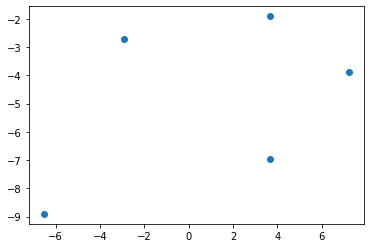


Covariance is positive definite.
(1000, 2)


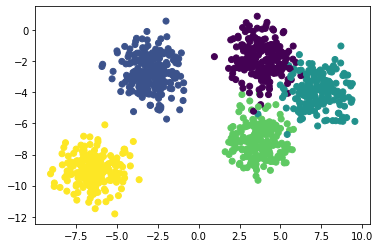

In [4]:
sample_blobs = sample_random_balls(5, var_x = 1, var_y = 1, var_xy = 0)
print(sample_blobs.covariance)
plt.figure()
plt.scatter(sample_blobs.mu[:, 0], sample_blobs.mu[:, 1])
plt.show()

x, l = sample_blobs.sample(1000)

print(x.shape)

plt.figure()
plt.scatter(x[:, 0], x[:, 1], c = l)
plt.show()

## Optimise model

Beginning K-means...

 Beginning outer iteration 0...
Outer iteration 0: inertia: 26146.1151744876
Outer iteration 0: inertia: 17828.250769123017
Outer iteration 0: inertia: 12461.50816766325
Outer iteration 0: inertia: 11901.274898768856
Outer iteration 0: inertia: 11901.274898768856

 Beginning outer iteration 1...
Outer iteration 1: inertia: 32558.79156814001
Outer iteration 1: inertia: 19094.27318046763
Outer iteration 1: inertia: 13697.47214781979
Outer iteration 1: inertia: 11901.274898768856
Outer iteration 1: inertia: 11901.274898768856

 Beginning outer iteration 2...
Outer iteration 2: inertia: 11997.508657084067
Outer iteration 2: inertia: 11901.274898768856
Outer iteration 2: inertia: 11901.274898768856

 Beginning outer iteration 3...
Outer iteration 3: inertia: 22154.929118889206
Outer iteration 3: inertia: 13955.079503258381
Outer iteration 3: inertia: 11901.274898768856
Outer iteration 3: inertia: 11901.274898768856

 Beginning outer iteration 4...
Outer iteration 4: in

Beginning K-means...

 Beginning outer iteration 0...
Outer iteration 0: inertia: 10412.066555330373
Outer iteration 0: inertia: 9661.338601740848
Outer iteration 0: inertia: 9155.370339590208
Outer iteration 0: inertia: 9061.122075630923
Outer iteration 0: inertia: 9061.0432575124
Outer iteration 0: inertia: 9061.0432575124

 Beginning outer iteration 1...
Outer iteration 1: inertia: 10764.30713445463
Outer iteration 1: inertia: 10085.405551610173
Outer iteration 1: inertia: 9650.930403118731
Outer iteration 1: inertia: 9398.000709559887
Outer iteration 1: inertia: 8967.17909933322
Outer iteration 1: inertia: 8059.397311870356
Outer iteration 1: inertia: 7206.014058430938
Outer iteration 1: inertia: 6573.462349588517
Outer iteration 1: inertia: 6360.978299448003
Outer iteration 1: inertia: 6360.978299448003

 Beginning outer iteration 2...
Outer iteration 2: inertia: 14389.766062665693
Outer iteration 2: inertia: 11600.200096039725
Outer iteration 2: inertia: 9740.441141358817
Outer i

Outer iteration 33: inertia: 6367.023931280232
Outer iteration 33: inertia: 6360.978299448003
Outer iteration 33: inertia: 6360.978299448003

 Beginning outer iteration 34...
Outer iteration 34: inertia: 11921.497818356524
Outer iteration 34: inertia: 9123.360354828863
Outer iteration 34: inertia: 9066.611102556326
Outer iteration 34: inertia: 9061.085608250152
Outer iteration 34: inertia: 9060.984940300248
Outer iteration 34: inertia: 9060.984940300248

 Beginning outer iteration 35...
Outer iteration 35: inertia: 9808.84361331542
Outer iteration 35: inertia: 9061.085608250152
Outer iteration 35: inertia: 9060.984940300248
Outer iteration 35: inertia: 9060.984940300248

 Beginning outer iteration 36...
Outer iteration 36: inertia: 19809.516440066895
Outer iteration 36: inertia: 10141.128739919717
Outer iteration 36: inertia: 9701.557730285964
Outer iteration 36: inertia: 9195.51121633466
Outer iteration 36: inertia: 9063.63844114662
Outer iteration 36: inertia: 9061.122075630923
Outer

C:\Users\ryanb.LAPTOP-4EHB9TVB\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\ryanb.LAPTOP-4EHB9TVB\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Outer iteration 27: inertia: 4018.9193584523787
Outer iteration 27: inertia: 3967.569283758997
Outer iteration 27: inertia: 3830.1744508834854
Outer iteration 27: inertia: 3667.8471633299637
Outer iteration 27: inertia: 3580.115644266257
Outer iteration 27: inertia: 3523.1745914331377
Outer iteration 27: inertia: 3521.0150877383535
Outer iteration 27: inertia: 3520.89895731947
Outer iteration 27: inertia: 3520.89895731947

 Beginning outer iteration 28...
Outer iteration 28: inertia: 8986.81189897721
Outer iteration 28: inertia: 7549.0189570320945
Outer iteration 28: inertia: 7443.441868253676
Outer iteration 28: inertia: 7439.147853737339
Outer iteration 28: inertia: 7434.525040013534
Outer iteration 28: inertia: 7432.729924134739
Outer iteration 28: inertia: 7432.729924134739

 Beginning outer iteration 29...
Outer iteration 29: inertia: 9391.956157525683
Outer iteration 29: inertia: 4201.163017327008
Outer iteration 29: inertia: 3565.641362613653
Outer iteration 29: inertia: 3521.01

Beginning K-means...

 Beginning outer iteration 0...
Outer iteration 0: inertia: 8127.681038572538
Outer iteration 0: inertia: 7421.1452313476975
Outer iteration 0: inertia: 7378.499513657597
Outer iteration 0: inertia: 7360.382777459149
Outer iteration 0: inertia: 7343.265303715323
Outer iteration 0: inertia: 7335.1453395898225
Outer iteration 0: inertia: 7331.660481455293
Outer iteration 0: inertia: 7328.850928411011
Outer iteration 0: inertia: 7322.732068224073
Outer iteration 0: inertia: 7318.887144260226
Outer iteration 0: inertia: 7315.55369254071
Outer iteration 0: inertia: 7313.696011753098
Outer iteration 0: inertia: 7310.977915100885
Outer iteration 0: inertia: 7306.301220851659
Outer iteration 0: inertia: 7302.517919361117
Outer iteration 0: inertia: 7299.076628323225
Outer iteration 0: inertia: 7297.220225396431
Outer iteration 0: inertia: 7296.028587464953
Outer iteration 0: inertia: 7295.854789892606
Outer iteration 0: inertia: 7295.284160991998
Outer iteration 0: inerti

Outer iteration 18: inertia: 7228.384961652369
Outer iteration 18: inertia: 7147.764396198872
Outer iteration 18: inertia: 6845.483473208889
Outer iteration 18: inertia: 5690.729523236741
Outer iteration 18: inertia: 2541.059079460948
Outer iteration 18: inertia: 1951.173542613425
Outer iteration 18: inertia: 1948.0294338868139
Outer iteration 18: inertia: 1947.7041820542934
Outer iteration 18: inertia: 1947.7041820542934

 Beginning outer iteration 19...
Outer iteration 19: inertia: 8411.31961770256
Outer iteration 19: inertia: 7288.224360213336
Outer iteration 19: inertia: 6590.501518492921
Outer iteration 19: inertia: 3796.8512094932516
Outer iteration 19: inertia: 1960.876496000091
Outer iteration 19: inertia: 1947.7041820542934
Outer iteration 19: inertia: 1947.7041820542934

 Beginning outer iteration 20...
Outer iteration 20: inertia: 8458.850244404373
Outer iteration 20: inertia: 7388.32389524542
Outer iteration 20: inertia: 7349.593762807407
Outer iteration 20: inertia: 7333.2

Outer iteration 38: inertia: 3395.1930258823413
Outer iteration 38: inertia: 3394.1829628523674
Outer iteration 38: inertia: 3391.48296576983
Outer iteration 38: inertia: 3389.512637583573
Outer iteration 38: inertia: 3387.540858365065
Outer iteration 38: inertia: 3378.2849719396486
Outer iteration 38: inertia: 3364.870137765092
Outer iteration 38: inertia: 3359.3292407134577
Outer iteration 38: inertia: 3356.4720818845385
Outer iteration 38: inertia: 3348.2326205486634
Outer iteration 38: inertia: 3328.8639521174596
Outer iteration 38: inertia: 3256.407340011979
Outer iteration 38: inertia: 3020.5300561059557
Outer iteration 38: inertia: 2278.173201584892
Outer iteration 38: inertia: 1962.7290224096355
Outer iteration 38: inertia: 1949.3809859146802
Outer iteration 38: inertia: 1947.7041820542934
Outer iteration 38: inertia: 1947.7041820542934

 Beginning outer iteration 39...
Outer iteration 39: inertia: 11448.609082215256
Outer iteration 39: inertia: 7321.774200560257
Outer iteratio

Outer iteration 14: inertia: 2084.669874825684
Outer iteration 14: inertia: 1826.3235653762354
Outer iteration 14: inertia: 1812.8629554625106
Outer iteration 14: inertia: 1811.5389388794893
Outer iteration 14: inertia: 1811.2402500906217
Outer iteration 14: inertia: 1810.1791786597464
Outer iteration 14: inertia: 1809.8064205072687
Outer iteration 14: inertia: 1809.402488936513
Outer iteration 14: inertia: 1809.2837401754425
Outer iteration 14: inertia: 1809.2837401754425

 Beginning outer iteration 15...
Outer iteration 15: inertia: 5093.383956455551
Outer iteration 15: inertia: 4576.099690042102
Outer iteration 15: inertia: 4507.000981308746
Outer iteration 15: inertia: 4475.360011052891
Outer iteration 15: inertia: 4431.0226804773265
Outer iteration 15: inertia: 4318.945299197951
Outer iteration 15: inertia: 4066.4557612626713
Outer iteration 15: inertia: 3545.6186540273347
Outer iteration 15: inertia: 3375.1314750785546
Outer iteration 15: inertia: 3366.9274503898205
Outer iterati

Outer iteration 29: inertia: 7088.824692782063
Outer iteration 29: inertia: 6968.219044211306
Outer iteration 29: inertia: 6582.914362842069
Outer iteration 29: inertia: 4870.886343303751
Outer iteration 29: inertia: 1889.8667862290345
Outer iteration 29: inertia: 1809.8649534095146
Outer iteration 29: inertia: 1807.1630184973446
Outer iteration 29: inertia: 1806.0332949042902
Outer iteration 29: inertia: 1805.2039237506106
Outer iteration 29: inertia: 1804.6262002555534
Outer iteration 29: inertia: 1804.6262002555534

 Beginning outer iteration 30...
Outer iteration 30: inertia: 8277.40601961616
Outer iteration 30: inertia: 7134.913603455307
Outer iteration 30: inertia: 6616.963337359817
Outer iteration 30: inertia: 4582.697399529354
Outer iteration 30: inertia: 1853.1832522969694
Outer iteration 30: inertia: 1806.2579320568207
Outer iteration 30: inertia: 1805.9122393406276
Outer iteration 30: inertia: 1805.9122393406276

 Beginning outer iteration 31...
Outer iteration 31: inertia: 

Outer iteration 43: inertia: 1826.3234051325908
Outer iteration 43: inertia: 1825.3353204812527
Outer iteration 43: inertia: 1824.8376749081758
Outer iteration 43: inertia: 1824.1919813529205
Outer iteration 43: inertia: 1823.7692762650177
Outer iteration 43: inertia: 1823.0143148781242
Outer iteration 43: inertia: 1820.4938839685958
Outer iteration 43: inertia: 1819.2779690650425
Outer iteration 43: inertia: 1819.01055221476
Outer iteration 43: inertia: 1818.8807860622987
Outer iteration 43: inertia: 1816.194321319984
Outer iteration 43: inertia: 1811.819971438671
Outer iteration 43: inertia: 1808.7269201937095
Outer iteration 43: inertia: 1806.3396555160061
Outer iteration 43: inertia: 1805.9122393406274
Outer iteration 43: inertia: 1805.9122393406274

 Beginning outer iteration 44...
Outer iteration 44: inertia: 4806.674050378703
Outer iteration 44: inertia: 3645.2471007090294
Outer iteration 44: inertia: 3411.5367036964635
Outer iteration 44: inertia: 3324.7065586042672
Outer itera

Outer iteration 11: inertia: 1652.3979140948845
Outer iteration 11: inertia: 1651.833885061007
Outer iteration 11: inertia: 1651.192835913845
Outer iteration 11: inertia: 1651.033346160019
Outer iteration 11: inertia: 1650.927107044438
Outer iteration 11: inertia: 1650.8614394230774
Outer iteration 11: inertia: 1650.8614394230774

 Beginning outer iteration 12...
Outer iteration 12: inertia: 5295.976023869011
Outer iteration 12: inertia: 4178.940533538765
Outer iteration 12: inertia: 3875.6995501841516
Outer iteration 12: inertia: 3822.2376558478045
Outer iteration 12: inertia: 3773.5228320907354
Outer iteration 12: inertia: 3744.171614000456
Outer iteration 12: inertia: 3711.572156432727
Outer iteration 12: inertia: 3645.8515636096063
Outer iteration 12: inertia: 3492.268049984009
Outer iteration 12: inertia: 3337.847871079307
Outer iteration 12: inertia: 3259.301520922369
Outer iteration 12: inertia: 3217.8418221122006
Outer iteration 12: inertia: 3217.725691693317
Outer iteration 12

Outer iteration 24: inertia: 1920.1717708605715
Outer iteration 24: inertia: 1702.5649857210701
Outer iteration 24: inertia: 1681.7777608405183
Outer iteration 24: inertia: 1675.554105715984
Outer iteration 24: inertia: 1671.3862922787034
Outer iteration 24: inertia: 1670.5391006263799
Outer iteration 24: inertia: 1669.4906169432
Outer iteration 24: inertia: 1668.8978549114772
Outer iteration 24: inertia: 1668.4212710337943
Outer iteration 24: inertia: 1668.4212710337943

 Beginning outer iteration 25...
Outer iteration 25: inertia: 4205.172184691951
Outer iteration 25: inertia: 2049.805633541773
Outer iteration 25: inertia: 1746.639187441144
Outer iteration 25: inertia: 1741.454819171671
Outer iteration 25: inertia: 1741.0678216564722
Outer iteration 25: inertia: 1740.3168567227044
Outer iteration 25: inertia: 1740.0925809199694
Outer iteration 25: inertia: 1740.0925809199694

 Beginning outer iteration 26...
Outer iteration 26: inertia: 3854.374648897807
Outer iteration 26: inertia: 

Outer iteration 39: inertia: 1704.611207821271
Outer iteration 39: inertia: 1690.777300948088
Outer iteration 39: inertia: 1684.659787100577
Outer iteration 39: inertia: 1679.580366841028
Outer iteration 39: inertia: 1674.268557268573
Outer iteration 39: inertia: 1671.448705884123
Outer iteration 39: inertia: 1668.308799371607
Outer iteration 39: inertia: 1665.7987449671036
Outer iteration 39: inertia: 1662.8650790902382
Outer iteration 39: inertia: 1660.7441369045007
Outer iteration 39: inertia: 1658.7281648765443
Outer iteration 39: inertia: 1657.2600235663322
Outer iteration 39: inertia: 1656.8420749933673
Outer iteration 39: inertia: 1656.8250162027182
Outer iteration 39: inertia: 1656.8250162027182

 Beginning outer iteration 40...
Outer iteration 40: inertia: 2936.7444904607564
Outer iteration 40: inertia: 1864.0094969725492
Outer iteration 40: inertia: 1694.6436473541403
Outer iteration 40: inertia: 1665.7223540661446
Outer iteration 40: inertia: 1659.334449517719
Outer iteratio

Outer iteration 9: inertia: 1515.4471790393868
Outer iteration 9: inertia: 1512.7989048529298
Outer iteration 9: inertia: 1511.5528358346994
Outer iteration 9: inertia: 1511.1215652583871
Outer iteration 9: inertia: 1511.0123413761369
Outer iteration 9: inertia: 1510.8421436898686
Outer iteration 9: inertia: 1510.5436322784615
Outer iteration 9: inertia: 1510.5436322784615

 Beginning outer iteration 10...
Outer iteration 10: inertia: 1689.620019825816
Outer iteration 10: inertia: 1630.0797501784873
Outer iteration 10: inertia: 1606.8782382824343
Outer iteration 10: inertia: 1589.5613773010198
Outer iteration 10: inertia: 1572.422226087744
Outer iteration 10: inertia: 1558.2326432124519
Outer iteration 10: inertia: 1549.095577395285
Outer iteration 10: inertia: 1545.1534017746103
Outer iteration 10: inertia: 1542.920288155827
Outer iteration 10: inertia: 1542.3677022154723
Outer iteration 10: inertia: 1542.1124237970482
Outer iteration 10: inertia: 1541.8514276397793
Outer iteration 10

Outer iteration 21: inertia: 1538.2235407524356
Outer iteration 21: inertia: 1535.0102860090208
Outer iteration 21: inertia: 1531.0885620094746
Outer iteration 21: inertia: 1528.6551886591299
Outer iteration 21: inertia: 1527.5023002110283
Outer iteration 21: inertia: 1527.0302616777794
Outer iteration 21: inertia: 1526.4928009761652
Outer iteration 21: inertia: 1525.2218298422079
Outer iteration 21: inertia: 1522.9212607497586
Outer iteration 21: inertia: 1517.4161320550074
Outer iteration 21: inertia: 1514.331874400239
Outer iteration 21: inertia: 1511.8103104532372
Outer iteration 21: inertia: 1510.6805868601825
Outer iteration 21: inertia: 1509.851215706503
Outer iteration 21: inertia: 1509.273492211446
Outer iteration 21: inertia: 1509.273492211446

 Beginning outer iteration 22...
Outer iteration 22: inertia: 3327.744434436658
Outer iteration 22: inertia: 1800.501817230754
Outer iteration 22: inertia: 1578.0483873778778
Outer iteration 22: inertia: 1571.385507234788
Outer iterati

Outer iteration 30: inertia: 1569.8244781876026
Outer iteration 30: inertia: 1568.2722992824347
Outer iteration 30: inertia: 1566.7217784675634
Outer iteration 30: inertia: 1563.9635506889701
Outer iteration 30: inertia: 1561.433718510885
Outer iteration 30: inertia: 1560.571827320332
Outer iteration 30: inertia: 1559.8920358435237
Outer iteration 30: inertia: 1559.4388197210696
Outer iteration 30: inertia: 1559.4388197210696

 Beginning outer iteration 31...
Outer iteration 31: inertia: 1701.96557549291
Outer iteration 31: inertia: 1592.795460260584
Outer iteration 31: inertia: 1580.6330923673067
Outer iteration 31: inertia: 1578.0505149559372
Outer iteration 31: inertia: 1577.4184620904473
Outer iteration 31: inertia: 1577.4184620904473

 Beginning outer iteration 32...
Outer iteration 32: inertia: 1797.0229166030674
Outer iteration 32: inertia: 1627.877402287136
Outer iteration 32: inertia: 1603.1531497854103
Outer iteration 32: inertia: 1592.4854404775308
Outer iteration 32: inerti

Outer iteration 44: inertia: 1596.5188480359445
Outer iteration 44: inertia: 1588.4236754723443
Outer iteration 44: inertia: 1582.8678533811485
Outer iteration 44: inertia: 1579.8372092967265
Outer iteration 44: inertia: 1579.036002977715
Outer iteration 44: inertia: 1578.9621193864855
Outer iteration 44: inertia: 1578.7523240439743
Outer iteration 44: inertia: 1578.7523240439743

 Beginning outer iteration 45...
Outer iteration 45: inertia: 2919.8699444094
Outer iteration 45: inertia: 1732.5310639061368
Outer iteration 45: inertia: 1590.5112264737554
Outer iteration 45: inertia: 1570.4844372132325
Outer iteration 45: inertia: 1564.6430485141552
Outer iteration 45: inertia: 1563.2100261914893
Outer iteration 45: inertia: 1561.8870052270988
Outer iteration 45: inertia: 1561.3139067147224
Outer iteration 45: inertia: 1560.8041104287179
Outer iteration 45: inertia: 1560.1013743080964
Outer iteration 45: inertia: 1559.033633209134
Outer iteration 45: inertia: 1557.9708761853817
Outer itera

Outer iteration 8: inertia: 1385.204899828254
Outer iteration 8: inertia: 1384.9147835120596
Outer iteration 8: inertia: 1384.9147835120596

 Beginning outer iteration 9...
Outer iteration 9: inertia: 2848.0156795877806
Outer iteration 9: inertia: 1839.010278318337
Outer iteration 9: inertia: 1541.436085436595
Outer iteration 9: inertia: 1517.1466410186385
Outer iteration 9: inertia: 1512.3588067074293
Outer iteration 9: inertia: 1510.426095181147
Outer iteration 9: inertia: 1509.970681572945
Outer iteration 9: inertia: 1509.6411224968188
Outer iteration 9: inertia: 1509.4759822830106
Outer iteration 9: inertia: 1509.4759822830106

 Beginning outer iteration 10...
Outer iteration 10: inertia: 2725.389528909562
Outer iteration 10: inertia: 2082.737940662638
Outer iteration 10: inertia: 1565.2611737327734
Outer iteration 10: inertia: 1493.0994490982303
Outer iteration 10: inertia: 1477.774165572255
Outer iteration 10: inertia: 1473.8934727872133
Outer iteration 10: inertia: 1468.21299206

Outer iteration 19: inertia: 1460.3059745374808
Outer iteration 19: inertia: 1460.225224439595
Outer iteration 19: inertia: 1460.225224439595

 Beginning outer iteration 20...
Outer iteration 20: inertia: 1750.3399961254493

 Beginning outer iteration 21...
Outer iteration 21: inertia: 1967.0280704009629
Outer iteration 21: inertia: 1573.6262840457603
Outer iteration 21: inertia: 1461.0560720985561
Outer iteration 21: inertia: 1449.4520137994114
Outer iteration 21: inertia: 1446.063917411247
Outer iteration 21: inertia: 1443.185483675127
Outer iteration 21: inertia: 1441.20018754834
Outer iteration 21: inertia: 1439.2333415317003
Outer iteration 21: inertia: 1438.5435867076844
Outer iteration 21: inertia: 1437.9910769420505
Outer iteration 21: inertia: 1437.9636746924723
Outer iteration 21: inertia: 1437.9141859336294
Outer iteration 21: inertia: 1437.8605256948172
Outer iteration 21: inertia: 1437.7815663124222
Outer iteration 21: inertia: 1437.6258789667222
Outer iteration 21: inerti

Outer iteration 32: inertia: 1397.2613547516942

 Beginning outer iteration 33...
Outer iteration 33: inertia: 2687.5124761150155
Outer iteration 33: inertia: 1642.3576288376598
Outer iteration 33: inertia: 1521.7725289474372
Outer iteration 33: inertia: 1501.2216321458159
Outer iteration 33: inertia: 1492.9724607257117
Outer iteration 33: inertia: 1486.5168089462004
Outer iteration 33: inertia: 1477.2735874355503
Outer iteration 33: inertia: 1473.9766923114373
Outer iteration 33: inertia: 1471.8061354264028
Outer iteration 33: inertia: 1469.9505611736267
Outer iteration 33: inertia: 1468.6281529511893
Outer iteration 33: inertia: 1467.107604081979
Outer iteration 33: inertia: 1464.9430610409026
Outer iteration 33: inertia: 1462.689486266532
Outer iteration 33: inertia: 1460.261953643458
Outer iteration 33: inertia: 1456.5354452138668
Outer iteration 33: inertia: 1453.7769272314576
Outer iteration 33: inertia: 1451.757368816875
Outer iteration 33: inertia: 1450.7850238208262
Outer iter

Outer iteration 43: inertia: 1418.3196489484512
Outer iteration 43: inertia: 1416.5617340087301
Outer iteration 43: inertia: 1414.9462309383548
Outer iteration 43: inertia: 1412.2601043038912
Outer iteration 43: inertia: 1411.36438973447
Outer iteration 43: inertia: 1411.2597722718085
Outer iteration 43: inertia: 1410.7642798325762
Outer iteration 43: inertia: 1410.1874225751046
Outer iteration 43: inertia: 1409.8936828920498
Outer iteration 43: inertia: 1409.6445909211013
Outer iteration 43: inertia: 1409.2674840665343
Outer iteration 43: inertia: 1409.2674840665343

 Beginning outer iteration 44...
Outer iteration 44: inertia: 7052.89141012162
Outer iteration 44: inertia: 2091.5855453493214
Outer iteration 44: inertia: 1534.1816134462704
Outer iteration 44: inertia: 1492.5391384981926
Outer iteration 44: inertia: 1477.1278889524215
Outer iteration 44: inertia: 1468.2410662917664
Outer iteration 44: inertia: 1462.9383796371944
Outer iteration 44: inertia: 1459.1924544231115
Outer iter

Outer iteration 8: inertia: 1414.7805798244815
Outer iteration 8: inertia: 1413.8427555903504
Outer iteration 8: inertia: 1412.7519455951913
Outer iteration 8: inertia: 1411.7891098969699
Outer iteration 8: inertia: 1411.4724616965275
Outer iteration 8: inertia: 1410.208574579128
Outer iteration 8: inertia: 1406.7300174929585
Outer iteration 8: inertia: 1403.9136378377568
Outer iteration 8: inertia: 1397.6083153371087
Outer iteration 8: inertia: 1393.1132257280624
Outer iteration 8: inertia: 1390.0451432577693
Outer iteration 8: inertia: 1386.7812672933064
Outer iteration 8: inertia: 1382.817536418943
Outer iteration 8: inertia: 1378.960667449948
Outer iteration 8: inertia: 1371.678075568845
Outer iteration 8: inertia: 1366.1296172369139
Outer iteration 8: inertia: 1361.2243713880312
Outer iteration 8: inertia: 1358.6673077461496
Outer iteration 8: inertia: 1356.4413735864252
Outer iteration 8: inertia: 1355.625430425939
Outer iteration 8: inertia: 1355.4759352253554
Outer iteration 8:

Outer iteration 27: inertia: 1326.3372962971068
Outer iteration 27: inertia: 1326.051311150708
Outer iteration 27: inertia: 1325.9097492058772
Outer iteration 27: inertia: 1325.69429572612
Outer iteration 27: inertia: 1325.5141060961216
Outer iteration 27: inertia: 1325.3252625264029
Outer iteration 27: inertia: 1324.8767653379339
Outer iteration 27: inertia: 1323.2851744878137
Outer iteration 27: inertia: 1321.931118615836
Outer iteration 27: inertia: 1321.8541960778948
Outer iteration 27: inertia: 1321.8541960778948

 Beginning outer iteration 28...
Outer iteration 28: inertia: 1785.4417331496186
Outer iteration 28: inertia: 1422.3548377674404
Outer iteration 28: inertia: 1393.2429000810423
Outer iteration 28: inertia: 1382.7823202821519
Outer iteration 28: inertia: 1379.1293551174747
Outer iteration 28: inertia: 1376.088526140078
Outer iteration 28: inertia: 1373.9211930803444
Outer iteration 28: inertia: 1373.259653711149
Outer iteration 28: inertia: 1372.936778903348
Outer iterati

Outer iteration 42: inertia: 1290.3461646781898
Outer iteration 42: inertia: 1284.9668381963406
Outer iteration 42: inertia: 1278.9317903149117
Outer iteration 42: inertia: 1275.7828064341925
Outer iteration 42: inertia: 1273.9950534598258
Outer iteration 42: inertia: 1273.5090560383908
Outer iteration 42: inertia: 1273.5090560383908

 Beginning outer iteration 43...
Outer iteration 43: inertia: 1412.665027809933
Outer iteration 43: inertia: 1327.568397997772
Outer iteration 43: inertia: 1302.6319812525921
Outer iteration 43: inertia: 1292.5123707304958
Outer iteration 43: inertia: 1288.7329125245542
Outer iteration 43: inertia: 1285.6523400202777
Outer iteration 43: inertia: 1282.9290124224203
Outer iteration 43: inertia: 1281.4695577518087
Outer iteration 43: inertia: 1279.0775967585205
Outer iteration 43: inertia: 1276.4569242352666
Outer iteration 43: inertia: 1275.947902304696
Outer iteration 43: inertia: 1275.8279891692366
Outer iteration 43: inertia: 1275.8279891692366

 Beginni

Outer iteration 6: inertia: 1322.567206357788
Outer iteration 6: inertia: 1322.455302131752
Outer iteration 6: inertia: 1322.3725404921206
Outer iteration 6: inertia: 1321.9795099437695
Outer iteration 6: inertia: 1321.9551676303709
Outer iteration 6: inertia: 1321.9551676303709

 Beginning outer iteration 7...
Outer iteration 7: inertia: 3090.3347080734743
Outer iteration 7: inertia: 2978.1590744284226
Outer iteration 7: inertia: 2970.4496682515273
Outer iteration 7: inertia: 2967.199860872246
Outer iteration 7: inertia: 2965.2587808353937
Outer iteration 7: inertia: 2963.7606585765425
Outer iteration 7: inertia: 2960.993200186289
Outer iteration 7: inertia: 2956.4868460548623
Outer iteration 7: inertia: 2950.704458906869
Outer iteration 7: inertia: 2931.37407744744
Outer iteration 7: inertia: 2801.991314130282
Outer iteration 7: inertia: 2184.2316699126095
Outer iteration 7: inertia: 1602.8839155395842
Outer iteration 7: inertia: 1424.8814337492167
Outer iteration 7: inertia: 1409.13

Outer iteration 19: inertia: 1336.8728938895874
Outer iteration 19: inertia: 1332.4773711321527
Outer iteration 19: inertia: 1329.5566917376225
Outer iteration 19: inertia: 1327.1241373326868
Outer iteration 19: inertia: 1325.0560273963158
Outer iteration 19: inertia: 1322.9710690641377
Outer iteration 19: inertia: 1319.142094738651
Outer iteration 19: inertia: 1313.451071891634
Outer iteration 19: inertia: 1308.8657628407996
Outer iteration 19: inertia: 1303.2870959562551
Outer iteration 19: inertia: 1296.3705056706683
Outer iteration 19: inertia: 1294.5154101305566
Outer iteration 19: inertia: 1293.7226617099084
Outer iteration 19: inertia: 1293.1008443431685
Outer iteration 19: inertia: 1292.994934536009
Outer iteration 19: inertia: 1292.994934536009

 Beginning outer iteration 20...
Outer iteration 20: inertia: 1445.6432341611826
Outer iteration 20: inertia: 1345.883794337873
Outer iteration 20: inertia: 1301.5749890349464
Outer iteration 20: inertia: 1278.8017802391796
Outer itera

Outer iteration 31: inertia: 1264.610118492734
Outer iteration 31: inertia: 1262.2991773087708
Outer iteration 31: inertia: 1260.747582246036
Outer iteration 31: inertia: 1260.0189968167042
Outer iteration 31: inertia: 1260.0189968167042

 Beginning outer iteration 32...
Outer iteration 32: inertia: 3060.7906263601512
Outer iteration 32: inertia: 1780.9797414004395
Outer iteration 32: inertia: 1312.5392125356702
Outer iteration 32: inertia: 1275.6932109879658
Outer iteration 32: inertia: 1268.1239500177553
Outer iteration 32: inertia: 1265.1141807360266
Outer iteration 32: inertia: 1263.8418373991121
Outer iteration 32: inertia: 1261.9238114186765
Outer iteration 32: inertia: 1260.7485798096184
Outer iteration 32: inertia: 1258.110802992932
Outer iteration 32: inertia: 1255.738461579594
Outer iteration 32: inertia: 1254.0253892314363
Outer iteration 32: inertia: 1251.102480409512
Outer iteration 32: inertia: 1249.1057880250194
Outer iteration 32: inertia: 1248.5065119255096
Outer itera

Beginning K-means...

 Beginning outer iteration 0...
Outer iteration 0: inertia: 1462.7578467765657
Outer iteration 0: inertia: 1263.821402016763
Outer iteration 0: inertia: 1238.61389013425
Outer iteration 0: inertia: 1225.8768892948387
Outer iteration 0: inertia: 1219.0881069317766
Outer iteration 0: inertia: 1217.1492928049709
Outer iteration 0: inertia: 1215.085618931496
Outer iteration 0: inertia: 1213.747152574681
Outer iteration 0: inertia: 1212.2922773298799
Outer iteration 0: inertia: 1211.0859251545348
Outer iteration 0: inertia: 1209.5635642764628
Outer iteration 0: inertia: 1207.422759692609
Outer iteration 0: inertia: 1204.850989494602
Outer iteration 0: inertia: 1198.7326624345335
Outer iteration 0: inertia: 1192.9241201982322
Outer iteration 0: inertia: 1186.9352329734224
Outer iteration 0: inertia: 1181.394058816772
Outer iteration 0: inertia: 1176.4406601141054
Outer iteration 0: inertia: 1172.2584454797102
Outer iteration 0: inertia: 1166.9568358510655
Outer iteratio

Outer iteration 14: inertia: 1366.4403154230563
Outer iteration 14: inertia: 1336.2225904641996
Outer iteration 14: inertia: 1327.484885628116
Outer iteration 14: inertia: 1318.5539927667185
Outer iteration 14: inertia: 1308.8545629711873
Outer iteration 14: inertia: 1297.3467551017914
Outer iteration 14: inertia: 1294.2660165629184
Outer iteration 14: inertia: 1290.1936335166627
Outer iteration 14: inertia: 1285.669496100691
Outer iteration 14: inertia: 1282.815551405497
Outer iteration 14: inertia: 1278.337541112868
Outer iteration 14: inertia: 1276.586129751749
Outer iteration 14: inertia: 1275.346963079999
Outer iteration 14: inertia: 1274.1843759849487
Outer iteration 14: inertia: 1272.4114919891415
Outer iteration 14: inertia: 1269.1578696429578
Outer iteration 14: inertia: 1266.5818082627402
Outer iteration 14: inertia: 1263.308665042524
Outer iteration 14: inertia: 1261.8048448161724
Outer iteration 14: inertia: 1260.2476099169237
Outer iteration 14: inertia: 1259.646535149297


Outer iteration 21: inertia: 1137.6178490436942
Outer iteration 21: inertia: 1131.7321387322768
Outer iteration 21: inertia: 1125.9846463718275
Outer iteration 21: inertia: 1118.1679552401706
Outer iteration 21: inertia: 1110.3841631780656
Outer iteration 21: inertia: 1100.2937719601553
Outer iteration 21: inertia: 1092.8351204316375
Outer iteration 21: inertia: 1090.9852604842224
Outer iteration 21: inertia: 1090.0178545913932
Outer iteration 21: inertia: 1087.4168282683515
Outer iteration 21: inertia: 1086.9088288255455
Outer iteration 21: inertia: 1086.5487206042033
Outer iteration 21: inertia: 1085.9890150665733
Outer iteration 21: inertia: 1085.7930168273754
Outer iteration 21: inertia: 1085.6244692928406
Outer iteration 21: inertia: 1085.1578511280156
Outer iteration 21: inertia: 1084.2423680601746
Outer iteration 21: inertia: 1082.77106914774
Outer iteration 21: inertia: 1081.8327404238198
Outer iteration 21: inertia: 1081.4095493235457
Outer iteration 21: inertia: 1081.34936176

Outer iteration 31: inertia: 1204.6242212233772
Outer iteration 31: inertia: 1204.5910029713536
Outer iteration 31: inertia: 1204.5910029713536

 Beginning outer iteration 32...
Outer iteration 32: inertia: 2730.6560644966025
Outer iteration 32: inertia: 1514.8418503627204
Outer iteration 32: inertia: 1392.3724517864698
Outer iteration 32: inertia: 1375.2110199474537
Outer iteration 32: inertia: 1369.970140337141
Outer iteration 32: inertia: 1364.906742231646
Outer iteration 32: inertia: 1359.0018875548421
Outer iteration 32: inertia: 1351.6410036988098
Outer iteration 32: inertia: 1349.5077605470321
Outer iteration 32: inertia: 1347.0246693199288
Outer iteration 32: inertia: 1345.9055587509934
Outer iteration 32: inertia: 1343.7815537849801
Outer iteration 32: inertia: 1340.6877601706908
Outer iteration 32: inertia: 1337.0977255902262
Outer iteration 32: inertia: 1335.453800424021
Outer iteration 32: inertia: 1333.727109345465
Outer iteration 32: inertia: 1333.4739486487263
Outer iter

Outer iteration 48: inertia: 1180.1207613461904
Outer iteration 48: inertia: 1147.881915408778
Outer iteration 48: inertia: 1130.469281750153
Outer iteration 48: inertia: 1125.463733673034
Outer iteration 48: inertia: 1120.389377209252
Outer iteration 48: inertia: 1117.9837261408159
Outer iteration 48: inertia: 1116.7431206290175
Outer iteration 48: inertia: 1116.1106208981992
Outer iteration 48: inertia: 1115.6969832683114
Outer iteration 48: inertia: 1115.3581085390124
Outer iteration 48: inertia: 1115.2566773462977
Outer iteration 48: inertia: 1115.1172412294661
Outer iteration 48: inertia: 1115.0712851958906
Outer iteration 48: inertia: 1115.011325187725
Outer iteration 48: inertia: 1114.89840253173
Outer iteration 48: inertia: 1114.8669307505875
Outer iteration 48: inertia: 1114.8669307505875

 Beginning outer iteration 49...
Outer iteration 49: inertia: 1589.5408023532614
Outer iteration 49: inertia: 1332.3289551754092
Outer iteration 49: inertia: 1314.7756276819234
Outer iterati

Outer iteration 12: inertia: 1038.8288006652251
Outer iteration 12: inertia: 1027.3837869634708
Outer iteration 12: inertia: 1020.9647022332491
Outer iteration 12: inertia: 1016.9773161933442
Outer iteration 12: inertia: 1015.0212417179696
Outer iteration 12: inertia: 1013.70553441235
Outer iteration 12: inertia: 1012.6011763265404
Outer iteration 12: inertia: 1012.0518216870297
Outer iteration 12: inertia: 1011.7533102756227
Outer iteration 12: inertia: 1011.7533102756227

 Beginning outer iteration 13...
Outer iteration 13: inertia: 1256.0152164846097
Outer iteration 13: inertia: 1138.9050731437817
Outer iteration 13: inertia: 1089.4291322155414
Outer iteration 13: inertia: 1069.456857425159
Outer iteration 13: inertia: 1059.1994516657064
Outer iteration 13: inertia: 1053.0570131761906
Outer iteration 13: inertia: 1050.1579951020935
Outer iteration 13: inertia: 1048.8578355813245
Outer iteration 13: inertia: 1047.7929194402184
Outer iteration 13: inertia: 1047.1049059422435
Outer ite

Outer iteration 23: inertia: 1282.6916623078446
Outer iteration 23: inertia: 1268.5360753980394
Outer iteration 23: inertia: 1263.0557242161337
Outer iteration 23: inertia: 1258.5392957863364
Outer iteration 23: inertia: 1255.0250016402101
Outer iteration 23: inertia: 1254.0931995685773
Outer iteration 23: inertia: 1253.487547331745
Outer iteration 23: inertia: 1252.9350881006958
Outer iteration 23: inertia: 1252.6600504806586
Outer iteration 23: inertia: 1252.4959061694433
Outer iteration 23: inertia: 1252.4959061694433

 Beginning outer iteration 24...
Outer iteration 24: inertia: 2690.7411728807338

 Beginning outer iteration 25...
Outer iteration 25: inertia: 2548.900135625698
Outer iteration 25: inertia: 1198.1689248421615
Outer iteration 25: inertia: 1160.7032050254886
Outer iteration 25: inertia: 1142.7388516519268
Outer iteration 25: inertia: 1128.9620933023689
Outer iteration 25: inertia: 1115.0200310377254
Outer iteration 25: inertia: 1099.1191531835502
Outer iteration 25: in

Outer iteration 37: inertia: 1105.0078307326921
Outer iteration 37: inertia: 1092.1953227433455
Outer iteration 37: inertia: 1078.888833144883
Outer iteration 37: inertia: 1066.2174710259778
Outer iteration 37: inertia: 1054.8892309330229
Outer iteration 37: inertia: 1052.1552846385728
Outer iteration 37: inertia: 1051.0856275331482
Outer iteration 37: inertia: 1050.6011599891506
Outer iteration 37: inertia: 1050.2769698435698
Outer iteration 37: inertia: 1049.732769561
Outer iteration 37: inertia: 1049.6059178170715
Outer iteration 37: inertia: 1049.5531393223066
Outer iteration 37: inertia: 1049.4141780404727
Outer iteration 37: inertia: 1049.4141780404727

 Beginning outer iteration 38...
Outer iteration 38: inertia: 1397.1551991962888

 Beginning outer iteration 39...
Outer iteration 39: inertia: 1414.6492809436406
Outer iteration 39: inertia: 1296.2177333109519
Outer iteration 39: inertia: 1247.5382759982547
Outer iteration 39: inertia: 1218.3388853361046
Outer iteration 39: inert

Beginning K-means...

 Beginning outer iteration 0...
Outer iteration 0: inertia: 1109.1438863566832
Outer iteration 0: inertia: 1059.2999977342104
Outer iteration 0: inertia: 1037.7588653237742
Outer iteration 0: inertia: 1020.7879594138444
Outer iteration 0: inertia: 1012.6406971899937
Outer iteration 0: inertia: 1009.4800501763403
Outer iteration 0: inertia: 1008.0611361671356
Outer iteration 0: inertia: 1006.5839237066384
Outer iteration 0: inertia: 1005.0699396961875
Outer iteration 0: inertia: 1003.8185360014061
Outer iteration 0: inertia: 1002.2518292007659
Outer iteration 0: inertia: 1001.8238857212369
Outer iteration 0: inertia: 1000.692689741743
Outer iteration 0: inertia: 998.1068173867562
Outer iteration 0: inertia: 996.0180282748803
Outer iteration 0: inertia: 995.1563401931742
Outer iteration 0: inertia: 994.7894351293338
Outer iteration 0: inertia: 994.635202494993
Outer iteration 0: inertia: 994.635202494993

 Beginning outer iteration 1...
Outer iteration 1: inertia: 1

Outer iteration 14: inertia: 948.4229861612557
Outer iteration 14: inertia: 945.580896634675
Outer iteration 14: inertia: 944.8050293795156
Outer iteration 14: inertia: 943.876461401399
Outer iteration 14: inertia: 943.1946884630355
Outer iteration 14: inertia: 942.1807483870006
Outer iteration 14: inertia: 941.8169631036243
Outer iteration 14: inertia: 941.3232361886847
Outer iteration 14: inertia: 941.2158763492658
Outer iteration 14: inertia: 940.6995143941497
Outer iteration 14: inertia: 940.4389655044695
Outer iteration 14: inertia: 940.4389655044695

 Beginning outer iteration 15...
Outer iteration 15: inertia: 1192.4946768198577
Outer iteration 15: inertia: 1038.2425412964144
Outer iteration 15: inertia: 1003.6661495375467
Outer iteration 15: inertia: 985.314679581859
Outer iteration 15: inertia: 973.00586039444
Outer iteration 15: inertia: 968.1014117226891
Outer iteration 15: inertia: 964.6049984253781
Outer iteration 15: inertia: 963.5623526461873
Outer iteration 15: inertia:

Outer iteration 24: inertia: 926.007484566537
Outer iteration 24: inertia: 925.3739946140579
Outer iteration 24: inertia: 924.9076743959249
Outer iteration 24: inertia: 924.7392436901804
Outer iteration 24: inertia: 924.4329653683313
Outer iteration 24: inertia: 924.2522460962408
Outer iteration 24: inertia: 924.0867425394218
Outer iteration 24: inertia: 923.9013713162593
Outer iteration 24: inertia: 923.6543661426457
Outer iteration 24: inertia: 923.5262931760327
Outer iteration 24: inertia: 923.4792388647944
Outer iteration 24: inertia: 923.4792388647944

 Beginning outer iteration 25...
Outer iteration 25: inertia: 1460.3194166105889
Outer iteration 25: inertia: 1145.6624193395533
Outer iteration 25: inertia: 1095.2930538129367
Outer iteration 25: inertia: 1071.4151643358334
Outer iteration 25: inertia: 1057.8067270346933
Outer iteration 25: inertia: 1049.7741624877087
Outer iteration 25: inertia: 1043.1186469552997
Outer iteration 25: inertia: 1037.330294036862
Outer iteration 25: 

Outer iteration 37: inertia: 1087.703589507537
Outer iteration 37: inertia: 1086.3564471016366
Outer iteration 37: inertia: 1085.7766139194164
Outer iteration 37: inertia: 1085.351136559598
Outer iteration 37: inertia: 1084.8725761809428
Outer iteration 37: inertia: 1084.5516039372865
Outer iteration 37: inertia: 1084.3486517262797
Outer iteration 37: inertia: 1084.3233421319683
Outer iteration 37: inertia: 1084.3233421319683

 Beginning outer iteration 38...
Outer iteration 38: inertia: 1233.4019681661375
Outer iteration 38: inertia: 1143.6349402473681
Outer iteration 38: inertia: 1113.5518306517313
Outer iteration 38: inertia: 1093.5391990806397
Outer iteration 38: inertia: 1082.3935298960541
Outer iteration 38: inertia: 1073.0639774868507
Outer iteration 38: inertia: 1067.1788457137416
Outer iteration 38: inertia: 1064.8925061109849
Outer iteration 38: inertia: 1064.6950368393968
Outer iteration 38: inertia: 1063.982435520102
Outer iteration 38: inertia: 1062.9567152676118
Outer ite

Beginning K-means...

 Beginning outer iteration 0...
Outer iteration 0: inertia: 1305.3332031945013
Outer iteration 0: inertia: 1198.6188730597971
Outer iteration 0: inertia: 1159.6251324629097
Outer iteration 0: inertia: 1143.4936991447987
Outer iteration 0: inertia: 1134.9959214626926
Outer iteration 0: inertia: 1129.200117731668
Outer iteration 0: inertia: 1126.5998387357554
Outer iteration 0: inertia: 1125.361342228016
Outer iteration 0: inertia: 1124.9448743510932
Outer iteration 0: inertia: 1124.3628387312633
Outer iteration 0: inertia: 1123.673649343956
Outer iteration 0: inertia: 1123.3260630398495
Outer iteration 0: inertia: 1123.0531356123627
Outer iteration 0: inertia: 1122.7976679209994
Outer iteration 0: inertia: 1121.4853819920631
Outer iteration 0: inertia: 1120.6589106927188
Outer iteration 0: inertia: 1120.167089815366
Outer iteration 0: inertia: 1119.7283788391387
Outer iteration 0: inertia: 1119.5270136994445
Outer iteration 0: inertia: 1119.4152761611376
Outer iter

Outer iteration 11: inertia: 938.0319358209858
Outer iteration 11: inertia: 938.0319358209858

 Beginning outer iteration 12...
Outer iteration 12: inertia: 1197.9863798749147
Outer iteration 12: inertia: 1100.3742527794147
Outer iteration 12: inertia: 1058.59762095232
Outer iteration 12: inertia: 1041.3032613553619
Outer iteration 12: inertia: 1026.666511441146
Outer iteration 12: inertia: 1018.543957424778
Outer iteration 12: inertia: 1011.1641489860708
Outer iteration 12: inertia: 1006.079490794606
Outer iteration 12: inertia: 1005.3496442775208
Outer iteration 12: inertia: 1003.4918660402316
Outer iteration 12: inertia: 1002.2077584204785
Outer iteration 12: inertia: 1001.3363370802499
Outer iteration 12: inertia: 1001.0830420921347
Outer iteration 12: inertia: 1001.0185679550912
Outer iteration 12: inertia: 1001.0185679550912

 Beginning outer iteration 13...
Outer iteration 13: inertia: 1041.3924844887413
Outer iteration 13: inertia: 986.7805462878866
Outer iteration 13: inertia:

Outer iteration 23: inertia: 981.0470720819742
Outer iteration 23: inertia: 980.9872281020871
Outer iteration 23: inertia: 980.9872281020871

 Beginning outer iteration 24...
Outer iteration 24: inertia: 1229.370276736517
Outer iteration 24: inertia: 1073.9977854566102
Outer iteration 24: inertia: 1001.8115312564646
Outer iteration 24: inertia: 971.6302091893625
Outer iteration 24: inertia: 956.6212404198893
Outer iteration 24: inertia: 951.4028865947965
Outer iteration 24: inertia: 948.375746530106
Outer iteration 24: inertia: 945.461170570781
Outer iteration 24: inertia: 941.6532834036234
Outer iteration 24: inertia: 939.7877338952127
Outer iteration 24: inertia: 938.1399296895191
Outer iteration 24: inertia: 937.7179415975436
Outer iteration 24: inertia: 937.4181127727936
Outer iteration 24: inertia: 937.4181127727936

 Beginning outer iteration 25...
Outer iteration 25: inertia: 1096.036986850871
Outer iteration 25: inertia: 1007.148525614341
Outer iteration 25: inertia: 978.032729

Outer iteration 37: inertia: 961.2920499676343
Outer iteration 37: inertia: 961.1878703874852
Outer iteration 37: inertia: 961.1106092718342
Outer iteration 37: inertia: 961.1106092718342

 Beginning outer iteration 38...
Outer iteration 38: inertia: 1141.4069804241044
Outer iteration 38: inertia: 1050.9221422340304
Outer iteration 38: inertia: 1017.9709287452907
Outer iteration 38: inertia: 1001.9880626228992
Outer iteration 38: inertia: 990.5945839062448
Outer iteration 38: inertia: 979.0157683093996
Outer iteration 38: inertia: 968.3346053378779
Outer iteration 38: inertia: 957.2281975100394
Outer iteration 38: inertia: 947.1437477558042
Outer iteration 38: inertia: 936.3415174170785
Outer iteration 38: inertia: 923.9186061649543
Outer iteration 38: inertia: 915.3614573642928
Outer iteration 38: inertia: 908.5683402604898
Outer iteration 38: inertia: 905.0414788913916
Outer iteration 38: inertia: 900.153616252587
Outer iteration 38: inertia: 896.0250477353164
Outer iteration 38: ine


 Beginning outer iteration 48...
Outer iteration 48: inertia: 2780.6817209722603
Outer iteration 48: inertia: 1523.4948337492037
Outer iteration 48: inertia: 1326.1791205968782
Outer iteration 48: inertia: 1310.3461892113473
Outer iteration 48: inertia: 1298.871495868119
Outer iteration 48: inertia: 1288.6332437028773
Outer iteration 48: inertia: 1284.1196713052545
Outer iteration 48: inertia: 1282.1018441474762
Outer iteration 48: inertia: 1279.7584680646544
Outer iteration 48: inertia: 1277.1609826046179
Outer iteration 48: inertia: 1273.8209405066143
Outer iteration 48: inertia: 1265.2280421258904
Outer iteration 48: inertia: 1259.6208437692278
Outer iteration 48: inertia: 1252.2657319455773
Outer iteration 48: inertia: 1245.4701368067056
Outer iteration 48: inertia: 1243.0031487635908
Outer iteration 48: inertia: 1242.0085252983313
Outer iteration 48: inertia: 1241.7550776387511
Outer iteration 48: inertia: 1241.4258258788745
Outer iteration 48: inertia: 1240.740743467047
Outer it

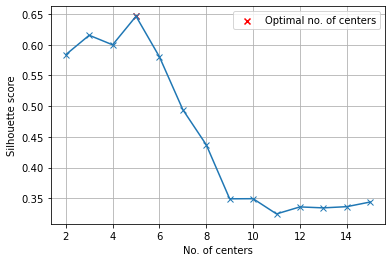

In [5]:
n_centers = np.arange(2, 16, 1)

centers = []
labels = []
silhouette_score = []
inertia = []

#Loop through different number of centers
for nc in n_centers:

    k_means_local = k_means(nc, 
                            'random', 
                            n_init = 50, 
                            max_iter = 100, 
                            verbose = True,
                            vectorise = True).fit(x, calculate_scores = True)
    
    centers.append(k_means_local.cluster_centers_)
    labels.append(k_means_local.predict(x))
    silhouette_score.append(k_means_local.silhouette_score)
    inertia.append(k_means_local.inertia_train_)

#Find optimal number of centers
pos_optimal = np.argmax(silhouette_score)
optimal_centers_kmeans = n_centers[pos_optimal]

#plotting
plt.figure()
plt.plot(n_centers, silhouette_score, marker = "x")
plt.xlabel("No. of centers")
plt.ylabel("Silhouette score")
plt.scatter(optimal_centers_kmeans, silhouette_score[pos_optimal], color = "r", marker = "x", label = "Optimal no. of centers")
plt.legend()
plt.grid()
plt.show()

### Visualise optimisation results and train best model

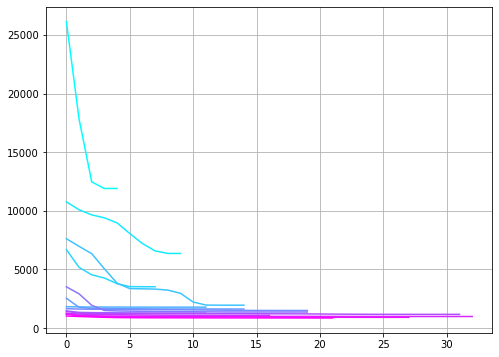

Beginning K-means...

 Beginning outer iteration 0...
Outer iteration 0: inertia: 2106.7898594184526
Outer iteration 0: inertia: 1950.6707804248601
Outer iteration 0: inertia: 1947.7041820542936
Outer iteration 0: inertia: 1947.7041820542936

 Beginning outer iteration 1...
Outer iteration 1: inertia: 9577.990882951015
Outer iteration 1: inertia: 6973.557615932183
Outer iteration 1: inertia: 5959.6442292924
Outer iteration 1: inertia: 4574.7610632019
Outer iteration 1: inertia: 3572.03285905662
Outer iteration 1: inertia: 3380.9800733716575
Outer iteration 1: inertia: 3366.338050466941
Outer iteration 1: inertia: 3349.924412196035
Outer iteration 1: inertia: 3263.1014441554084
Outer iteration 1: inertia: 2761.527954161315
Outer iteration 1: inertia: 2067.865447301184
Outer iteration 1: inertia: 1952.6046072352533
Outer iteration 1: inertia: 1948.1355694621416
Outer iteration 1: inertia: 1947.7041820542934
Outer iteration 1: inertia: 1947.7041820542934

 Beginning outer iteration 2...
O

Outer iteration 22: inertia: 1947.7041820542934
Outer iteration 22: inertia: 1947.7041820542934

 Beginning outer iteration 23...
Outer iteration 23: inertia: 8830.624423733125
Outer iteration 23: inertia: 7678.61828760919
Outer iteration 23: inertia: 7172.0530767797945
Outer iteration 23: inertia: 6645.03941511835
Outer iteration 23: inertia: 4353.739529073296
Outer iteration 23: inertia: 1968.6745958239896
Outer iteration 23: inertia: 1947.7041820542936
Outer iteration 23: inertia: 1947.7041820542936

 Beginning outer iteration 24...
Outer iteration 24: inertia: 15859.1074413968
Outer iteration 24: inertia: 4238.129197140571
Outer iteration 24: inertia: 3399.6532580542835
Outer iteration 24: inertia: 3388.593341418835
Outer iteration 24: inertia: 3384.5112266731035
Outer iteration 24: inertia: 3383.8545257896767
Outer iteration 24: inertia: 3383.8545257896767

 Beginning outer iteration 25...
Outer iteration 25: inertia: 8434.47630639156
Outer iteration 25: inertia: 7260.991350073051

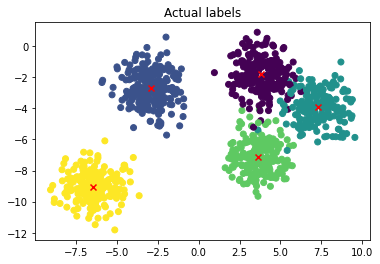

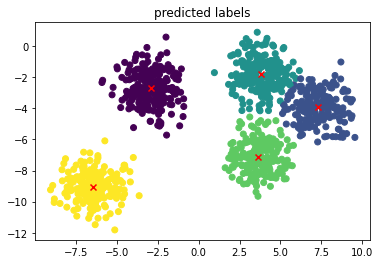

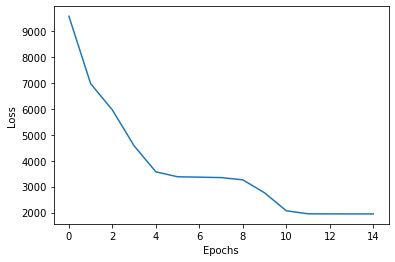

In [6]:
colors = plt.cm.cool(np.linspace(0, 1, len(n_centers)))

plt.figure(figsize = (8, 6))
for cnt, i in enumerate(n_centers):
    plt.plot(inertia[cnt], color = colors[cnt], label = str(i))
plt.grid()
plt.show()

#Fit the optimal model
k_means_optimal = k_means(optimal_centers_kmeans, 'random', 
                          n_init = 50, 
                          max_iter = 100, 
                          verbose = True).fit(x, calculate_scores = False)

labels_kmeans = k_means_optimal.predict(x)

plt.figure()
plt.title("Actual labels")
plt.scatter(x[:, 0], x[:, 1], c = l)
plt.scatter(k_means_optimal.cluster_centers_[:, 0], k_means_optimal.cluster_centers_[:, 1], c = "r", marker = "x")
plt.show()

plt.figure()
plt.title("predicted labels")
plt.scatter(x[:, 0], x[:, 1], c = labels_kmeans)
plt.scatter(k_means_optimal.cluster_centers_[:, 0], k_means_optimal.cluster_centers_[:, 1], c = "r", marker = "x")
plt.show()

plt.figure()
plt.plot(k_means_optimal.inertia_train_)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

### Compare to Sklearn k-means

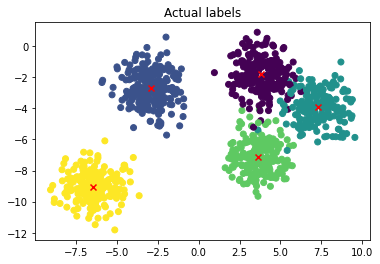

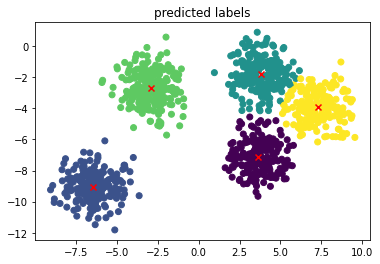

In [7]:
k_means_local = k_means_sklearn(optimal_centers_kmeans,
                                n_init = 50,
                                max_iter = 100)
k_means_local.fit(x)

labels_kmeans = k_means_local.predict(x)

plt.figure()
plt.title("Actual labels")
plt.scatter(x[:, 0], x[:, 1], c = l)
plt.scatter(k_means_local.cluster_centers_[:, 0], k_means_local.cluster_centers_[:, 1], c = "r", marker = "x")
plt.show()

plt.figure()
plt.title("predicted labels")
plt.scatter(x[:, 0], x[:, 1], c = labels_kmeans)
plt.scatter(k_means_local.cluster_centers_[:, 0], k_means_local.cluster_centers_[:, 1], c = "r", marker = "x")
plt.show()